In [ ]:
import tensorflow as tf
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.applications.resnet import ResNet101, preprocess_input
from glob import glob
import matplotlib.pyplot as plt
import os
import sys
from PIL import Image
import numpy as np
import platform
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score
from typing import List
from tensorflow.keras.callbacks import EarlyStopping
from livelossplot.inputs.keras import PlotLossesCallback
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import top_k_accuracy_score



# tf.debugging.set_log_device_placement(True)

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

# Обработка изображений и создание каталогов

Загружаем датасет отсюда:

https://www.kaggle.com/datasets/tanlikesmath/the-oxfordiiit-pet-dataset

In [ ]:
# Конфигурация путей
train_path         = "oxford_pets"
new_folder_breeds  = "oxford_pets_breeds"
new_folder_classes = "oxford_pets_classes"

# Список всех классов (пород) животных, отсортированный по категориям
pet_classes = [
    # Кошки
    'cat_Abyssinian', 'cat_Bengal',    'cat_Birman',     'cat_Bombay',    'cat_British',
    'cat_Egyptian',   'cat_Maine',     'cat_Persian',    'cat_Ragdoll',   'cat_Russian',
    'cat_Siamese',    'cat_Sphynx',
    
    # Собаки
    'dog_american',    'dog_basset',    'dog_beagle',     'dog_boxer',     'dog_chihuahua',
    'dog_english',     'dog_german',    'dog_great',      'dog_havanese',  'dog_japanese',
    'dog_keeshond',    'dog_leonberger','dog_miniature',  'dog_newfoundland', 'dog_pomeranian',
    'dog_pug',         'dog_saint',     'dog_samoyed',    'dog_scottish',  'dog_shiba',
    'dog_staffordshire','dog_wheaten',  'dog_yorkshire'
]

# Получаем список файлов и подкаталогов
files_path = [i for i in os.listdir(train_path)]
# Получаем уникальные категории (первые части имен до _)
folders = list(set([i.split('_')[0].lower() for i in os.listdir(train_path)]))

# Очищаем список категорий от системных файлов (начинающихся с .)
for name in folders:
    if name.startswith("."):
        folders.remove(name)

# --- Создание структуры для многоклассовой классификации (по породам) ---
try:
    os.mkdir(new_folder_breeds)
except FileExistsError:
    print(f"Папка '{new_folder_breeds}' уже существует")

# Создаем подкаталоги для каждой категории животных
for breed_folder in folders:
    try:
        os.mkdir(f"./{new_folder_breeds}/{breed_folder}")
    except FileExistsError:
        pass 

# --- Создание структуры для бинарной классификации (кошки/собаки) ---
try:
    os.mkdir(new_folder_classes)
except FileExistsError:
    print(f"Папка '{new_folder_classes}' уже существует")

# Создаем подкаталоги для кошек и собак
for animal_class in ['cat', 'dog']:
    try:
        os.mkdir(f"./{new_folder_classes}/{animal_class}")
    except FileExistsError:
        pass

Folder 'oxford_pets_breeds' already exists
Folder 'oxford_pets_classes' already exists


In [88]:
# Считываем все файлы из исходной общей папки и раскладываем их по каталогам в новой папке
for file in files_path:
    folder_name = file.split("_")[0].lower()
    try:
        Image.open(train_path + "/" + file).save(f"{new_folder_breeds}/{folder_name}/{file}")
    except:
        print(f"Error with file: {file}. Maybe it is broken?")

Error with file: Egyptian_Mau_167.jpg. Maybe it is broken?
Error with file: .DS_Store. Maybe it is broken?
Error with file: Abyssinian_5.jpg. Maybe it is broken?
Error with file: Egyptian_Mau_177.jpg. Maybe it is broken?
Error with file: Egyptian_Mau_139.jpg. Maybe it is broken?
Error with file: Abyssinian_34.jpg. Maybe it is broken?
Error with file: Egyptian_Mau_191.jpg. Maybe it is broken?
Error with file: Egyptian_Mau_145.jpg. Maybe it is broken?
Error with file: Egyptian_Mau_186.jpg. Maybe it is broken?
Error with file: Egyptian_Mau_14.jpg. Maybe it is broken?


In [106]:
# Считываем все файлы из исходной общей папки и раскладываем их по 2 каталогам в новой папке
for file in files_path:
    try:
        img = Image.open(train_path + "/" + file)
        for i in pet_classes:
            flnm = i.lower().split("_")
            if flnm[-1].lower() in file.lower().split("_"):
                img.save(f"./{new_folder_classes}/{flnm[0]}/{file}")
    except:
        print(f"Error with file: {file}. Maybe it is broken?")

# Чтение данных

In [ ]:
# Пути к директориям с данными
train_path         = "oxford_pets"
new_folder_breeds  = "oxford_pets_breeds"
new_folder_classes = "oxford_pets_classes"

# Создание тренировочного набора данных
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=new_folder_breeds,  # Директория с данными
    validation_split=0.2,         # 20% данных для валидации
    subset='training',            # Выбираем тренировочную часть
    seed=906,                     # Фиксируем random seed для воспроизводимости
    image_size=(224, 224),        # Размер изображений (224x224 пикселей)
    batch_size=8                  # Размер батча
)

# Создание валидационного набора данных
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=new_folder_breeds,  # Та же директория, что и для тренировочных данных
    validation_split=0.2,         # 20% данных для валидации
    subset='validation',          # Выбираем валидационную часть
    seed=906,                     # Тот же seed, что и для тренировочных данных
    image_size=(224, 224),        # Такой же размер изображений
    batch_size=8                  # Такой же размер батча
)

# Получаем имена классов из тренировочного набора
class_names = train_ds.class_names
print("Список классов:", class_names)

2025-04-09 20:36:51.927874: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-04-09 20:36:51.927901: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-09 20:36:51.927909: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-09 20:36:51.927927: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-09 20:36:51.927940: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Found 7381 files belonging to 35 classes.
Using 1476 files for validation.
['abyssinian', 'american', 'basset', 'beagle', 'bengal', 'birman', 'bombay', 'boxer', 'british', 'chihuahua

In [ ]:
# Подготовка тренировочных данных
# ---------------------------------
X_train, y_train = [], []  # Инициализируем пустые списки для признаков и меток

# Проходим по всем батчам в тренировочном наборе данных
for images, labels in train_ds:
    # Добавляем изображения и метки в списки, преобразуя тензоры в numpy массивы
    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())

# Преобразуем списки в numpy массивы для удобства работы
X_train = np.array(X_train)
y_train = np.array(y_train)

# Подготовка тестовых данных
# ---------------------------------
X_test, y_test = [], []    # Инициализируем пустые списки для признаков и меток

# Проходим по всем батчам в валидационном наборе данных
for images, labels in val_ds:
    # Добавляем изображения и метки в списки, преобразуя тензоры в numpy массивы
    X_test.extend(images.numpy())
    y_test.extend(labels.numpy())

# Преобразуем списки в numpy массивы
X_test = np.array(X_test)
y_test = np.array(y_test)

# Проверка размерностей данных
# ---------------------------------
print("Размерность X_train (изображения):", X_train.shape)  # (кол-во образцов, высота, ширина, каналы)
print("Размерность y_train (метки):", y_train.shape)        # (кол-во образцов,)
print("Размерность X_test (изображения):", X_test.shape)    # (кол-во образцов, высота, ширина, каналы)
print("Размерность y_test (метки):", y_test.shape)          # (кол-во образцов,)

Shape of X_train: (5905, 224, 224, 3)
Shape of y_train: (5905,)
Shape of X_test: (1476, 224, 224, 3)
Shape of y_test: (1476,)
2025-04-09 20:36:56.711963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# VGG16

In [ ]:
# Инициализация предобученной модели VGG16
# --------------------------------------------------
# Параметры:
# input_shape=(224,224,3) - размер входных изображений (224x224 пикселей, 3 канала RGB)
# weights='imagenet'      - используем веса, обученные на ImageNet
# include_top=False       - не включаем верхние (полносвязные) слои сети
vgg_16 = VGG16(input_shape=(224, 224, 3), 
               weights='imagenet', 
               include_top=False)

# Заморозка весов модели (предотвращение их обучения)
# --------------------------------------------------
# Делаем все слои модели необучаемыми
for layer in vgg_16.layers:
    layer.trainable = False  # отключаем обучение для каждого слоя

# Дополнительная заморозка всей модели (двойная страховка)
vgg_16.trainable = False

# Получение конфигурации модели
# --------------------------------------------------
# model_config содержит архитектурные параметры модели:
# - структуру слоев
# - их настройки
# - другие параметры конфигурации
model_config = vgg_16.get_config()

# Для просмотра структуры модели можно использовать:
# vgg_16.summary()

In [ ]:
# Создание дополнительных слоев поверх VGG16
# --------------------------------------------------
# Преобразуем выход VGG (4D тензор) в 2D (для полносвязных слоев)
x = tf.keras.layers.Flatten(name='flatten_layer')(vgg_16.output)

# Добавляем полносвязные слои:
x = tf.keras.layers.Dense(512, name='trainable_layer_1', activation="relu")(x)
x = tf.keras.layers.Dense(512, name='trainable_layer_2', activation="relu")(x)
x = tf.keras.layers.Dense(256, name='trainable_layer_3', activation="relu")(x)

# Выходной слой с количеством нейронов по числу классов
output = tf.keras.layers.Dense(
    len(class_names), 
    name='output_layer', 
    activation='softmax'  # Используем softmax для многоклассовой классификации
)(x)

# Создание конечной модели
# --------------------------------------------------
model = tf.keras.models.Model(
    name="VGG_16_transfer_learning",
    inputs=vgg_16.input,   # Вход от VGG16
    outputs=output         # Наш кастомный выход
)

# Компиляция модели
# --------------------------------------------------
model.compile(
    # Функция потерь для многоклассовой классификации
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    # Метрика - точность
    metrics=['accuracy'],
    # Оптимизатор Adagrad с learning rate 0.01
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01),
)

# Вывод информации о модели
# --------------------------------------------------
model.summary(show_trainable=True)

Model: "VGG_16_transfer_learning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 224, 224, 64)  │      1,792 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 224, 224, 64)  │     36,928 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 112, 112, 64)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 112, 112, 128) │     73,856 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 112, 112, 128) │    147,584 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 56, 56, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 56, 56, 256)   │    295,168 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 28, 28, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 28, 28, 512)   │  1,180,160 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 14, 14, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 7, 7, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_1 (Flatten)         │ (None, 25088)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ trainable_layer_1 (Dense)   │ (None, 512)           │ 12,845,568 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ trainable_layer_2 (Dense)   │ (None, 512)           │    262,656 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ trainable_layer_3 (Dense)   │ (None, 256)           │    131,328 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ output_layer (Dense)        │ (None, 35)            │      8,995 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 27,963,235 (106.67 MB)

 Trainable params: 13,248,547 (50.54 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Обучение через train_test_split

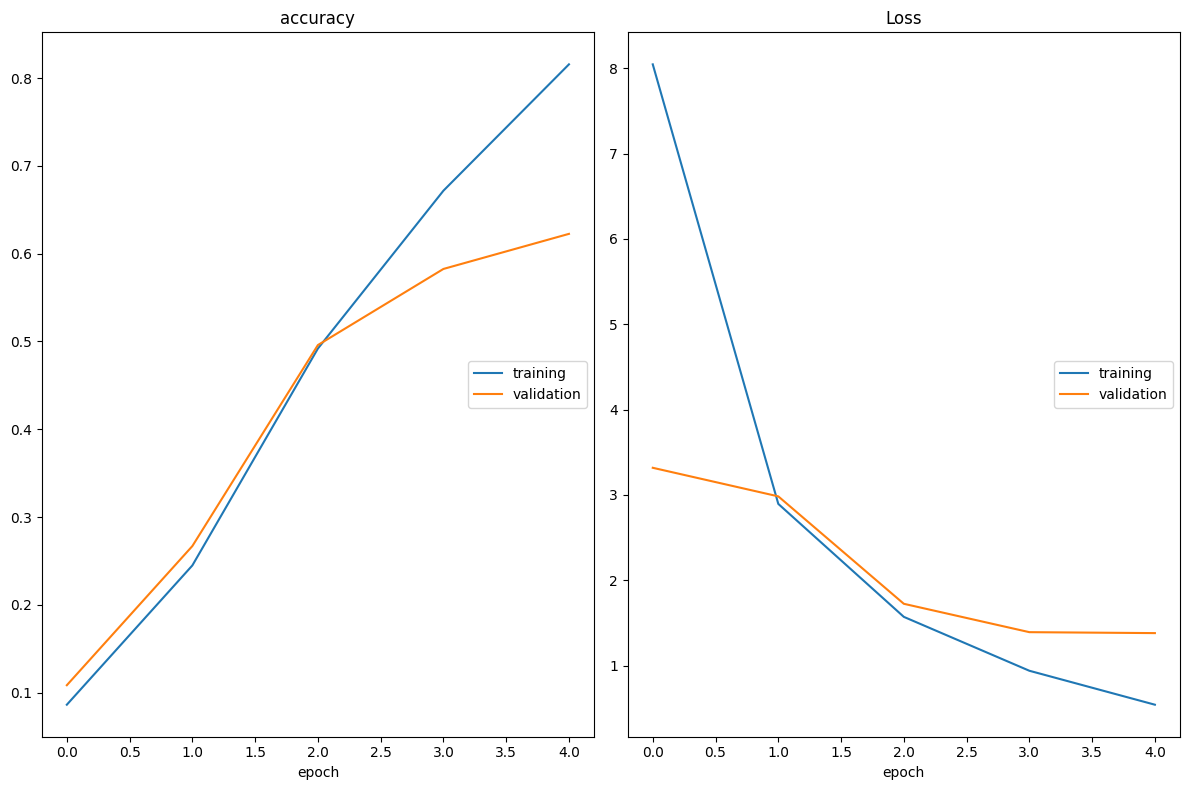

accuracy
	training         	 (min:    0.086, max:    0.816, cur:    0.816)
	validation       	 (min:    0.108, max:    0.623, cur:    0.623)
Loss
	training         	 (min:    0.543, max:    8.045, cur:    0.543)
	validation       	 (min:    1.382, max:    3.319, cur:    1.382)
739/739 ━━━━━━━━━━━━━━━━━━━━ 60s 81ms/step - accuracy: 0.8177 - loss: 0.5364 - val_accuracy: 0.6226 - val_loss: 1.3816


In [ ]:
# Инициализация callback'ов
# --------------------------------------------------
# 1. Визуализация потерь в реальном времени
plot_loss_callback = PlotLossesCallback()

# 2. Ранняя остановка при ухудшении качества
early_stopping = EarlyStopping(
    monitor='val_loss',         # Мониторим потерю на валидации
    patience=3,                 # Количество эпох без улучшения перед остановкой
    restore_best_weights=True,  # Возвращаем лучшие веса модели
    mode='min'                  # Режим минимизации метрики
)

# Обучение модели
# --------------------------------------------------
history = model.fit(
    X_train,                           # Обучающие данные
    y_train,                           # Обучающие метки
    validation_data=(X_test, y_test),  # Данные для валидации
    epochs=5,                          # Количество эпох обучения
    batch_size=8,                      # Размер батча
    verbose=1,                         # Уровень детализации вывода (1 - с прогрессбаром)
    callbacks=[
        early_stopping,                # Ранняя остановка
        plot_loss_callback             # Визуализация потерь
    ]
)

## Обучение через train_ds, val_ds

In [ ]:
# plot_loss_1 = PlotLossesCallback()

# hist = model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=5, 
#   # batch_size=32,
#   verbose=1,
#   callbacks=[
#       EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, mode='min'),
#       plot_loss_1
#       # tfa.callbacks.TQDMProgressBar()
#     ]
# )

In [50]:
# # loss
# plt.plot(hist.history['loss'], label='train loss')
# plt.plot(hist.history['val_loss'], label='val loss')
# plt.legend()
# plt.show()
# # plt.savefig('LossVal_loss')

# # accuracies
# plt.plot(hist.history['accuracy'], label='train accuracy')
# plt.plot(hist.history['val_accuracy'], label='val accuracy')
# plt.legend()
# plt.show()
# # plt.savefig('AccVal_acc')

## Валидация модели

In [9]:
model.save("./models/vgg_16.keras")

47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step


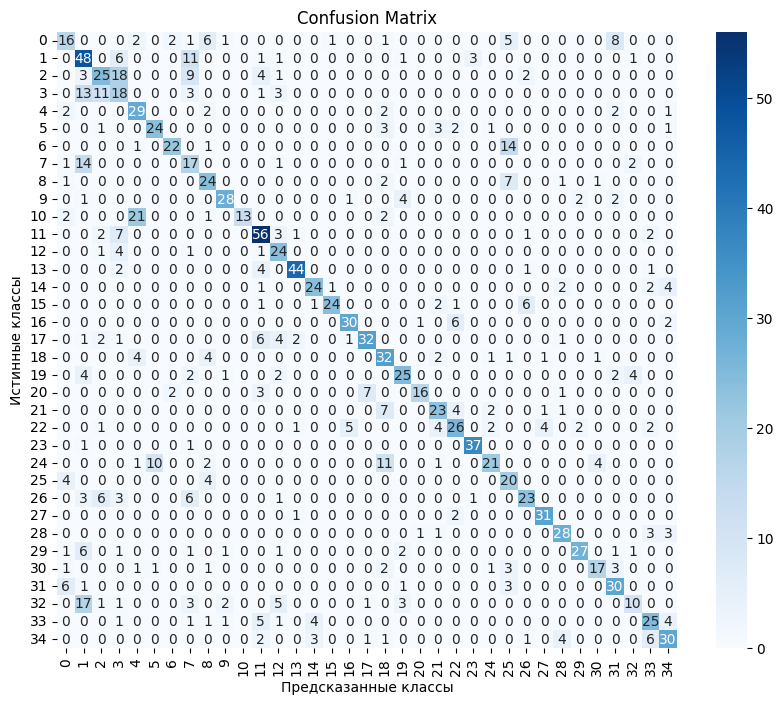

Accuracy VGG-16: 0.62


In [ ]:
predicted_classes = model.predict(X_test)
predicted_classes = np.argmax(predicted_classes, axis=1)

cm = confusion_matrix(y_test, predicted_classes)

# Отображение confusion matrix с использованием seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Confusion Matrix')
plt.show()

print(f"Accuracy VGG-16: {accuracy_score(y_test, predicted_classes):.2f}")

In [ ]:
# # Чтение одного изображения и предикт
# img = tf.keras.utils.load_img(
#     '/Users/Verbasik/Desktop/ai-lab-m2-convolutional-networks-1985Viacheslav-main/oxford_pets/Abyssinian_1.jpg',
#     color_mode="rgb",
#     target_size=(224,224,3),
#     interpolation="nearest",
#     keep_aspect_ratio=False,
# )
# input_img = np.array([tf.keras.utils.img_to_array(img)])
# np.argmax(model.predict(input_img), axis=1)

In [22]:
# vgg_16_results = model.evaluate(val_ds)
# print(f"VGG-16 accuracy: {vgg_16_results[1]:.4f}")

# VGG19

In [ ]:
# Инициализация модели VGG19 с предобученными весами
# --------------------------------------------------
# Параметры инициализации:
# - input_shape: размер входных изображений (224x224 пикселя, 3 канала RGB)
# - weights: используем веса, обученные на ImageNet
# - include_top: не включаем верхние полносвязные слои оригинальной сети
vgg_19 = VGG19(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)

# Заморозка весов модели (transfer learning подход)
# --------------------------------------------------
# 1. Замораживаем все слои по отдельности
for layer in vgg_19.layers:
    layer.trainable = False  # отключаем возможность обучения для каждого слоя

# 2. Дублирующая заморозка всей модели для надежности
vgg_19.trainable = False

# Получение конфигурации модели
# --------------------------------------------------
# model_config содержит полное описание архитектуры:
# - последовательность слоев
# - параметры каждого слоя
# - связи между слоями
model_config = vgg_19.get_config()

In [ ]:
# Создаем головную часть модели поверх замороженного VGG19
# ---------------------------------------------------------
# Преобразуем 4D выход VGG19 в 2D для полносвязных слоев
x = tf.keras.layers.Flatten(name='flatten_layer')(vgg_19.output)

# Добавляем кастомные полносвязные слои:
x = tf.keras.layers.Dense(512, name='dense_1', activation='relu')(x)
x = tf.keras.layers.Dense(512, name='dense_2', activation='relu')(x)
x = tf.keras.layers.Dense(256, name='dense_3', activation='relu')(x)

# Выходной слой с количеством нейронов по числу классов
output = tf.keras.layers.Dense(
    len(class_names),
    name='output_layer',
    activation='softmax'  # Используем softmax для вероятностного вывода
)(x)

# Собираем полную модель
# ---------------------------------------------------------
model = tf.keras.models.Model(
    name="VGG19_Transfer_Learning",
    inputs=vgg_19.input,  # Вход от VGG19
    outputs=output        # Наша кастомная головная часть
)

# Компиляция модели
# ---------------------------------------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adagrad(
        learning_rate=0.01,  # Начальная скорость обучения
    ),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False  # Так как используем softmax
    ),
    metrics=['accuracy']  # Метрика для мониторинга
)

# Визуализация архитектуры
# ---------------------------------------------------------
model.summary(show_trainable=True)


Model: "VGG_19_transfer_learning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 224, 224, 64)  │      1,792 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 224, 224, 64)  │     36,928 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 112, 112, 64)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 112, 112, 128) │     73,856 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 112, 112, 128) │    147,584 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 56, 56, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 56, 56, 256)   │    295,168 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv4 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 28, 28, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 28, 28, 512)   │  1,180,160 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv4 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 14, 14, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv4 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 7, 7, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_2 (Flatten)         │ (None, 25088)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ trainable_layer_1 (Dense)   │ (None, 512)           │ 12,845,568 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ trainable_layer_2 (Dense)   │ (None, 512)           │    262,656 │   Y 

 Total params: 33,272,931 (126.93 MB)

 Trainable params: 13,248,547 (50.54 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

## Обучение через train_test_split

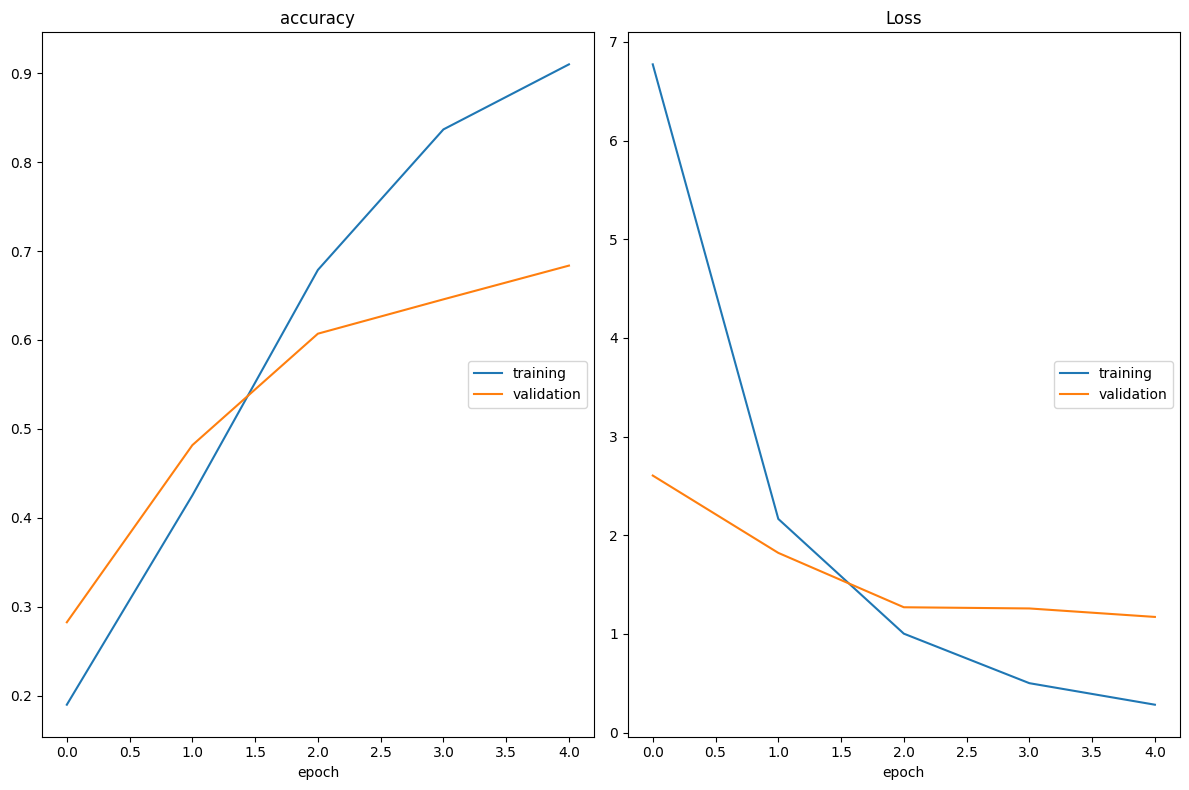

accuracy
	training         	 (min:    0.190, max:    0.910, cur:    0.910)
	validation       	 (min:    0.283, max:    0.684, cur:    0.684)
Loss
	training         	 (min:    0.282, max:    6.773, cur:    0.282)
	validation       	 (min:    1.172, max:    2.605, cur:    1.172)
739/739 ━━━━━━━━━━━━━━━━━━━━ 88s 119ms/step - accuracy: 0.9105 - loss: 0.2772 - val_accuracy: 0.6836 - val_loss: 1.1717


In [ ]:
plot_loss_1 = PlotLossesCallback()

hist = model.fit(
  X_train,
  y_train,
  validation_data=(X_test, y_test),
  epochs=5, 
  batch_size=8,
  verbose=1,
  callbacks=[
      EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, mode='min'),
      plot_loss_1
    ]
)

## Валидация модели

In [28]:
model.save("./models/vgg_19.keras")

47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 333ms/step


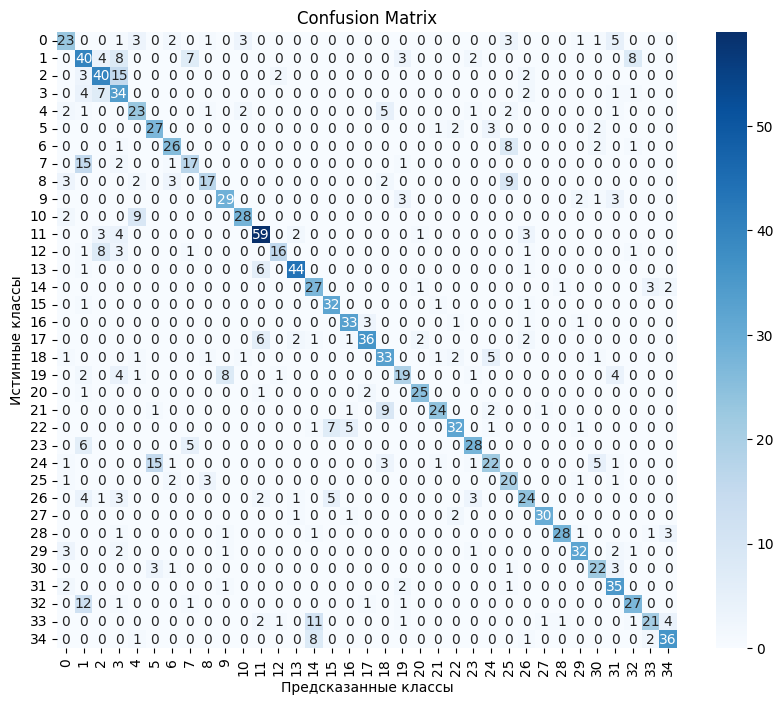

Accuracy VGG-19: 0.68


In [ ]:
predicted_classes = model.predict(X_test)
predicted_classes = np.argmax(predicted_classes, axis=1)

cm = confusion_matrix(y_test, predicted_classes)

# Отображение confusion matrix с использованием seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Confusion Matrix')
plt.show()

print(f"Accuracy VGG-19: {accuracy_score(y_test, predicted_classes):.2f}")

# ResNet

In [ ]:
# Инициализация модели ResNet101 с предобученными весами
# ---------------------------------------------------------
# Параметры инициализации:
# - input_shape: размер входных изображений (224x224, 3 канала RGB)
# - weights: загрузка весов, обученных на ImageNet
# - include_top: исключаем верхние слои для кастомизации
resnet_101 = ResNet101(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False,  # Не включаем FC-слои
    pooling='avg'      # Глобальный average pooling для выхода
)

# Заморозка слоев ResNet101 для Transfer Learning
# ---------------------------------------------------------
# 1. Замораживаем все слои базовой модели
for layer in resnet_101.layers:
    layer.trainable = False

# 2. Дополнительная заморозка всей модели
resnet_101.trainable = False

# Получение конфигурации модели
# ---------------------------------------------------------
model_config = resnet_101.get_config()

In [ ]:
# Создание кастомной головной части модели
# ---------------------------------------------------------
# 1. Преобразование выхода ResNet101 (используем GlobalAveragePooling вместо Flatten)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(resnet_101.output)

# 2. Добавление полносвязных слоев с BatchNormalization и Dropout
x = tf.keras.layers.Dense(512, name='fc1', activation='relu')(x)
x = tf.keras.layers.BatchNormalization(name='bn1')(x)
x = tf.keras.layers.Dropout(0.3, name='dropout1')(x)

x = tf.keras.layers.Dense(512, name='fc2', activation='relu')(x)
x = tf.keras.layers.BatchNormalization(name='bn2')(x)
x = tf.keras.layers.Dropout(0.3, name='dropout2')(x)

x = tf.keras.layers.Dense(256, name='fc3', activation='relu')(x)
x = tf.keras.layers.BatchNormalization(name='bn3')(x)

# 3. Выходной слой
output = tf.keras.layers.Dense(
    len(class_names),
    name='output',
    activation='softmax',
    kernel_regularizer=tf.keras.regularizers.l2(0.01)
)(x)

# Сборка полной модели
# ---------------------------------------------------------
model = tf.keras.models.Model(
    name="ResNet101_Transfer_Learning",
    inputs=resnet_101.input,
    outputs=output
)

# Компиляция модели с оптимизированными параметрами
# ---------------------------------------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[
        'accuracy',
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3_accuracy')
    ]
)

# Визуализация и проверка модели
# ---------------------------------------------------------
model.summary(show_trainable=True)

Model: "ResNet101_transfer_learning"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2     │ (None, 224,     │         0 │ -              │   -   │
│ (InputLayer)      │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_pad         │ (None, 230,     │         0 │ input_layer_2… │   -   │
│ (ZeroPadding2D)   │ 230, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_conv        │ (None, 112,     │     9,472 │ conv1_pad[0][… │   N   │
│ (Conv2D)          │ 112, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_bn          │ (None, 112,     │       256 │ conv1_conv[0]… │   N   │
│ (BatchNormalizat… │ 112, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_relu        │ (None, 112,     │         0 │ conv1_bn[0][0] │   -   │
│ (Activation)      │ 112, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ pool1_pad         │ (None, 114,     │         0 │ conv1_relu[0]… │   -   │
│ (ZeroPadding2D)   │ 114, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ pool1_pool        │ (None, 56, 56,  │         0 │ pool1_pad[0][… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_1_c… │ (None, 56, 56,  │     4,160 │ pool1_pool[0]… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_1_bn │ (None, 56, 56,  │       256 │ conv2_block1_… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_1_r… │ (None, 56, 56,  │         0 │ conv2_block1_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_2_c… │ (None, 56, 56,  │    36,928 │ conv2_block1_… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_2_bn │ (None, 56, 56,  │       256 │ conv2_block1_… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_2_r… │ (None, 56, 56,  │         0 │ conv2_block1_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_0_c… │ (None, 56, 56,  │    16,640 │ pool1_pool[0]… │   N   │
│ (Conv2D)          │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_3_c… │ (None, 56, 56,  │    16,640 │ conv2_block1_… │   N   │
│ (Conv2D)          │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_0_bn │ (None, 56, 56,  │     1,024 │ conv2_block1_… │   N   │
│ (BatchNormalizat… │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_3_bn │ (None, 56, 56,  │     1,024 │ conv2_block1_… │   N 

 Total params: 94,441,891 (360.27 MB)

 Trainable params: 51,783,715 (197.54 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

## Обучение через train_test_split

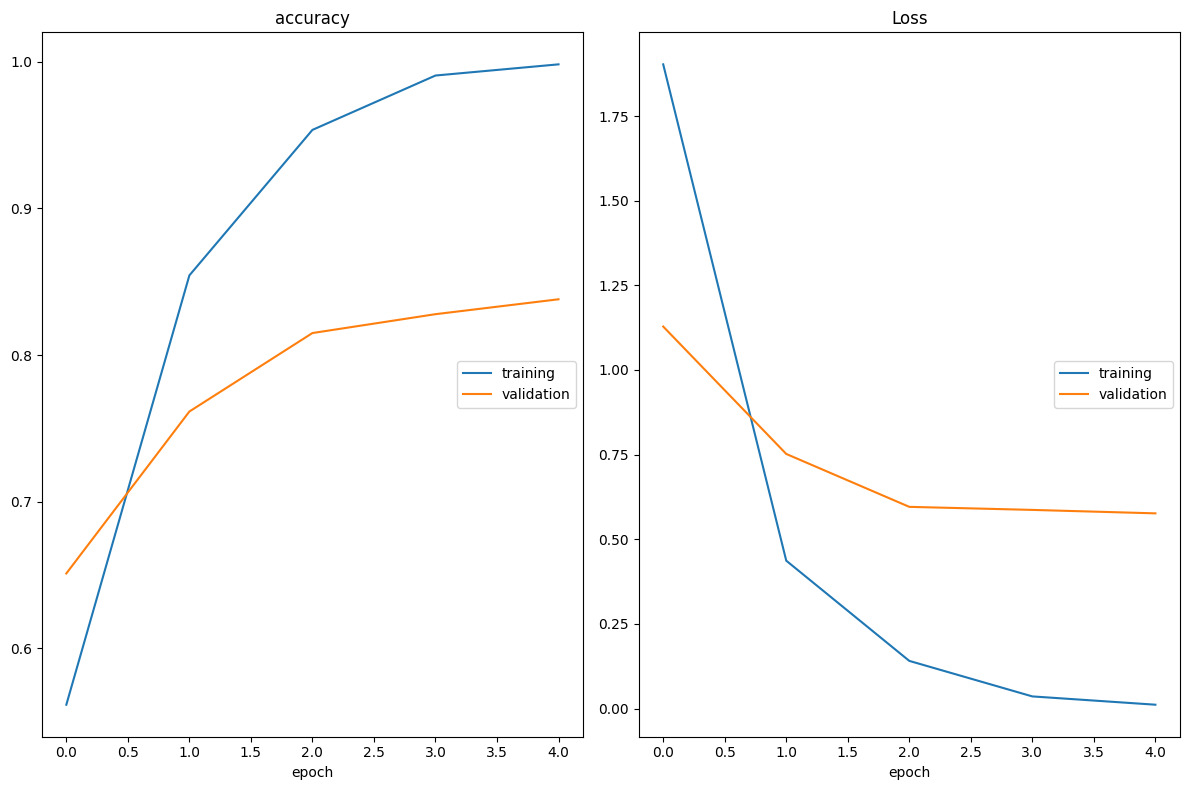

accuracy
	training         	 (min:    0.562, max:    0.998, cur:    0.998)
	validation       	 (min:    0.651, max:    0.838, cur:    0.838)
Loss
	training         	 (min:    0.011, max:    1.903, cur:    0.011)
	validation       	 (min:    0.577, max:    1.128, cur:    0.577)
739/739 ━━━━━━━━━━━━━━━━━━━━ 117s 158ms/step - accuracy: 0.9969 - loss: 0.0148 - val_accuracy: 0.8381 - val_loss: 0.5766


In [ ]:
plot_loss_1 = PlotLossesCallback()

hist = model.fit(
  X_train,
  y_train,
  validation_data=(X_test, y_test),
  epochs=5, 
  batch_size=8,
  verbose=1,
  callbacks=[
      EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, mode='min'),
      plot_loss_1
    ]
)

## Валидация модели

In [33]:
model.save("./models/resnet_101.keras")

47/47 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step


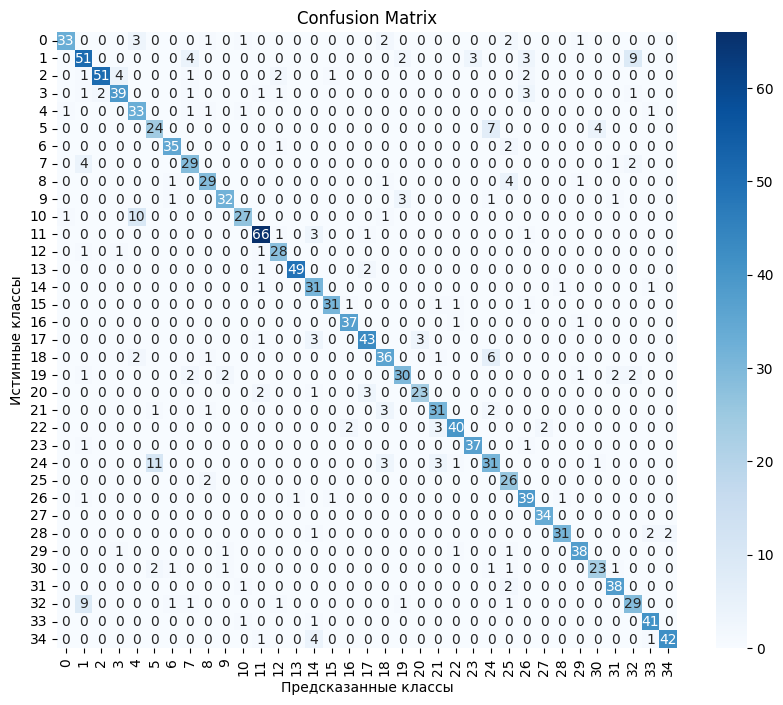

Accuracy ResNet101: 0.84


In [ ]:
predicted_classes = model.predict(X_test)
predicted_classes = np.argmax(predicted_classes, axis=1)

cm = confusion_matrix(y_test, predicted_classes)

# Отображение confusion matrix с использованием seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Confusion Matrix')
plt.show()

print(f"Accuracy ResNet101: {accuracy_score(y_test, predicted_classes):.2f}")

# Расчет ТОП-3 и ТОП-5 accuracy для лучшей модели

In [ ]:
model = tf.keras.models.load_model("./models/resnet_101.keras")
probabilities = model.predict(X_test)

47/47 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step


In [38]:
# top3_predictions = np.argsort(probabilities, axis=1)[:, -3:] # сортировка массива и выбираю топ-3
top3_accuracy = top_k_accuracy_score(y_test, probabilities, k=3)
print("Top-3 Accuracy:", top3_accuracy)

Top-3 Accuracy: 0.9701897018970189


In [39]:
# top5_predictions = np.argsort(probabilities, axis=1)[:, -5:] # сортировка массива и выбираю топ-5
top5_accuracy = top_k_accuracy_score(y_test, probabilities, k=5)
print("Top-5 Accuracy:", top5_accuracy)

Top-5 Accuracy: 0.9871273712737128


# Предсказание бинарной классификации

In [ ]:
train_path         = "oxford_pets"
new_folder_breeds  = "oxford_pets_breeds"
new_folder_classes = "oxford_pets_classes"

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory = new_folder_classes,
    validation_split = 0.2,
    subset='training',
    seed=906,
    image_size=(224,224),
    batch_size=8
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory = new_folder_classes,
    validation_split = 0.2,
    subset='validation',
    seed=906,
    image_size=(224,224),
    batch_size=8
)

class_names = train_ds.class_names
print(class_names)

Found 7381 files belonging to 2 classes.
Using 5905 files for training.
Found 7381 files belonging to 2 classes.
Using 1476 files for validation.
['cat', 'dog']


In [ ]:
# Разбивка на train/test
X_train, y_train = [], []
for images, labels in train_ds:
    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test, y_test = [], []
for images, labels in val_ds:
    X_test.extend(images.numpy())
    y_test.extend(labels.numpy())

X_test = np.array(X_test)
y_test = np.array(y_test)

# Проверка размерности данных
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:",  X_test.shape)
print("Shape of y_test:",  y_test.shape)

2025-04-09 17:13:29.219075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Shape of X_train: (5905, 224, 224, 3)
Shape of y_train: (5905,)
Shape of X_test: (1476, 224, 224, 3)
Shape of y_test: (1476,)
2025-04-09 17:13:31.938973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [53]:
model = tf.keras.models.load_model("./models/resnet_101.keras")

In [ ]:
for layer in model.layers:
    layer.trainable = False

# Получение всех слоев модели, кроме последнего
last_layer = model.layers[-2].output
new_output = tf.keras.layers.Dense(2, name='binary_output_layer', activation='softmax')(last_layer)
new_model = tf.keras.Model(name='transfer_learning_binary',inputs=model.input, outputs=new_output)
new_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01),
)
new_model.summary(show_trainable=True)

Model: "transfer_learning_binary"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2     │ (None, 224,     │         0 │ -              │   -   │
│ (InputLayer)      │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_pad         │ (None, 230,     │         0 │ input_layer_2… │   -   │
│ (ZeroPadding2D)   │ 230, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_conv        │ (None, 112,     │     9,472 │ conv1_pad[0][… │   N   │
│ (Conv2D)          │ 112, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_bn          │ (None, 112,     │       256 │ conv1_conv[0]… │   N   │
│ (BatchNormalizat… │ 112, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_relu        │ (None, 112,     │         0 │ conv1_bn[0][0] │   -   │
│ (Activation)      │ 112, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ pool1_pad         │ (None, 114,     │         0 │ conv1_relu[0]… │   -   │
│ (ZeroPadding2D)   │ 114, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ pool1_pool        │ (None, 56, 56,  │         0 │ pool1_pad[0][… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_1_c… │ (None, 56, 56,  │     4,160 │ pool1_pool[0]… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_1_bn │ (None, 56, 56,  │       256 │ conv2_block1_… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_1_r… │ (None, 56, 56,  │         0 │ conv2_block1_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_2_c… │ (None, 56, 56,  │    36,928 │ conv2_block1_… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_2_bn │ (None, 56, 56,  │       256 │ conv2_block1_… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_2_r… │ (None, 56, 56,  │         0 │ conv2_block1_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_0_c… │ (None, 56, 56,  │    16,640 │ pool1_pool[0]… │   N   │
│ (Conv2D)          │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_3_c… │ (None, 56, 56,  │    16,640 │ conv2_block1_… │   N   │
│ (Conv2D)          │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_0_bn │ (None, 56, 56,  │     1,024 │ conv2_block1_… │   N   │
│ (BatchNormalizat… │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_3_bn │ (None, 56, 56,  │     1,024 │ conv2_block1_… │   N 

 Total params: 94,433,410 (360.23 MB)

 Trainable params: 514 (2.01 KB)

 Non-trainable params: 94,432,896 (360.23 MB)

In [59]:
predicted_classes = new_model.predict(X_test)
predicted_classes = np.argmax(predicted_classes, axis=1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step


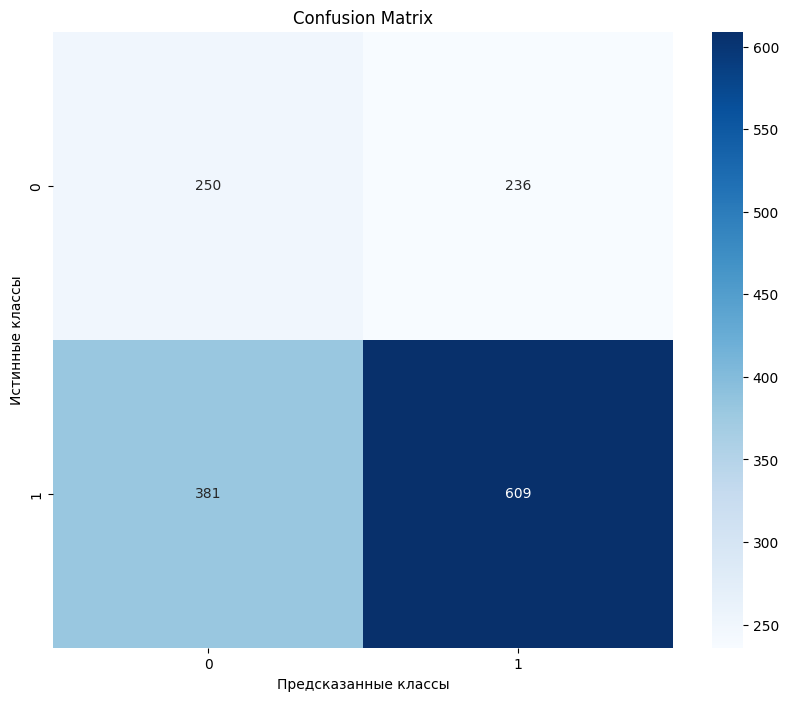

Accuracy ResNet101: 0.58


In [63]:
cm = confusion_matrix(y_test, predicted_classes)

# Отображение confusion matrix с использованием seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Confusion Matrix')
plt.show()

print(f"Accuracy ResNet101: {accuracy_score(y_test, predicted_classes):.2f}")

In [65]:
new_model.save("./models/resnet_101_binary.keras")